Load Julia packages (libraries) needed.

In [1]:
using StatisticalRethinking, CmdStan
#gr(size=(600,600));

ProjDir = rel_path("..", "scripts", "05")
cd(ProjDir)

### snippet 5.1

In [2]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';');
df = convert(DataFrame, wd);
df[!, :A] = scale(df[!, :MedianAgeMarriage]);
df[!, :D] = scale(df[!, :Divorce]);
first(df, 5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce
,String,String,Float64,Float64,Float64,Float64,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5
5,California,CA,37.25,26.8,19.1,0.39,8.0


### snippet 5.1

In [3]:
std(df[!, :MedianAgeMarriage])

ad = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] D; // Outcome
 vector[N] A; // Predictor
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
  vector[N] mu;
  a ~ normal(0, 0.2);
  bA ~ normal(0, 0.5);
  sigma ~ exponential(1);
  mu = a + bA * A;
  D ~ normal(mu , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [4]:
m5_1s = Stanmodel(name="MedianAgeDivorce", model=ad);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/05/tmp/MedianAgeDivorce.stan will be updated.



Input data for cmdstan

In [5]:
data = Dict("N" => length(df[!, :D]), "D" => df[!, :Divorce],
    "A" => df[!, :A]);

Sample using cmdstan

In [6]:
rc, chn, cnames = stan(m5_1s, data, ProjDir, diagnostics=false,
  summary=true, CmdStanDir=CMDSTAN_HOME);

Inference for Stan model: MedianAgeDivorce_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.054, 0.052, 0.055, 0.052) seconds, 0.21 seconds total
Sampling took (0.072, 0.081, 0.075, 0.071) seconds, 0.30 seconds total

                 Mean     MCSE  StdDev        5%    50%   95%  N_Eff  N_Eff/s    R_hat
lp__             -147  3.0e-02     1.2  -1.5e+02   -147  -146   1682     5629  1.0e+00
accept_stat__    0.92  1.4e-03   0.096   7.2e-01   0.95   1.0   5099    17061  1.0e+00
stepsize__       0.79  5.1e-02   0.072   6.8e-01   0.81  0.88    2.0      6.7  1.0e+14
treedepth__       2.3  1.1e-02    0.64   1.0e+00    2.0   3.0   3158    10566  1.0e+00
n_leapfrog__      5.9  1.0e-01     5.9   3.0e+00    3.0    15   3509    11741  1.0e+00
divergent__      0.00  0.0e+00    0.00   0.0e+00   0.00  0.00   2000     6692      nan
energy__          149  4.6e-02     1.7   1.5e+02    149   152   1455     4868  1.0e+00
a       

Describe the draws

In [7]:
describe(chn)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64   │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼───────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ a          │ 0.242249  │ 0.201169 │ 0.00318076 │ 0.00383801 │ 3404.41 │
│ 2   │ bA         │ -0.136325 │ 0.4764   │ 0.00753255 │ 0.0079807  │ 3364.14 │
│ 3   │ sigma      │ 9.01013   │ 0.854194 │ 0.013506   │ 0.0165232  │ 3191.02 │

Quantiles

│ Row │ parameters │ 2.5%      │ 25.0%     │ 50.0%     │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64   │ Float64   │ Float64   │ Float64  │ Float64  │
├─────┼────────────┼───────────┼───────────┼───────────┼──────────┼──────────┤
│ 1   │ a          │ -0.160054 │ 0.104788  │ 0.243329  │ 0.380723 │ 0.627051 │
│ 2   │ bA         │ -1.05644  │ -0.453656 │ -0.139188 │ 0.180883 │ 0.802534 │
│ 3   │ sigma      │ 7.5342

Plot the density of posterior draws

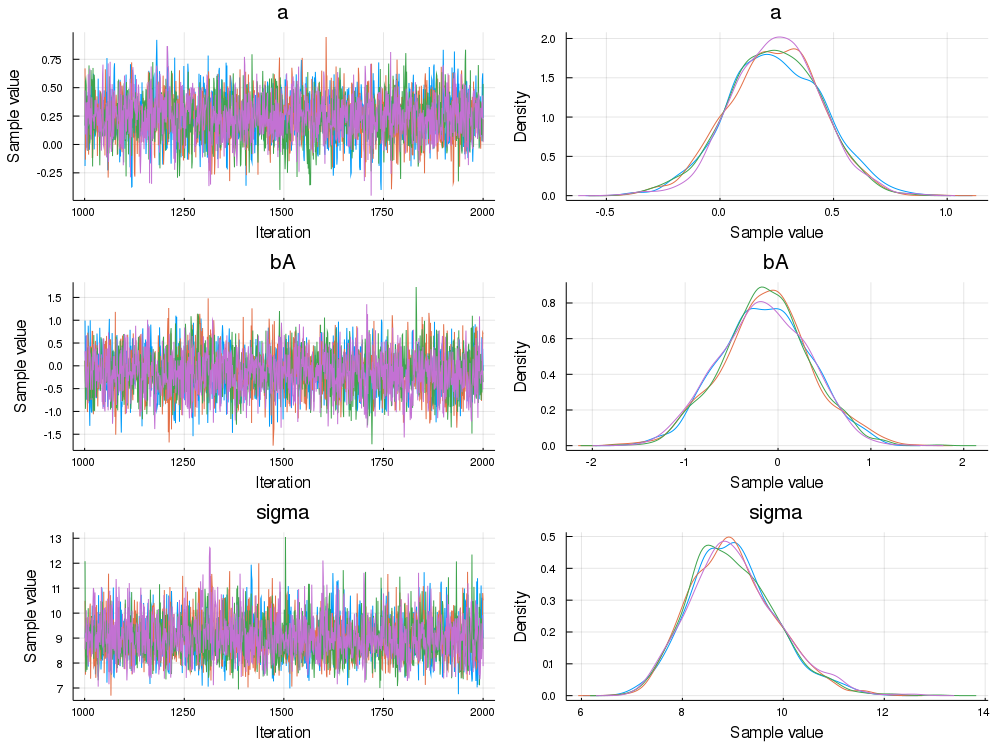

In [8]:
plot(chn)

Result rethinking

In [9]:
rethinking = "
       mean   sd  5.5% 94.5% n_eff Rhat
a      9.69 0.22  9.34 10.03  2023    1
bA    -1.04 0.21 -1.37 -0.71  1882    1
sigma  1.51 0.16  1.29  1.79  1695    1
"

"\n       mean   sd  5.5% 94.5% n_eff Rhat\na      9.69 0.22  9.34 10.03  2023    1\nbA    -1.04 0.21 -1.37 -0.71  1882    1\nsigma  1.51 0.16  1.29  1.79  1695    1\n"

Plot regression line using means and observations

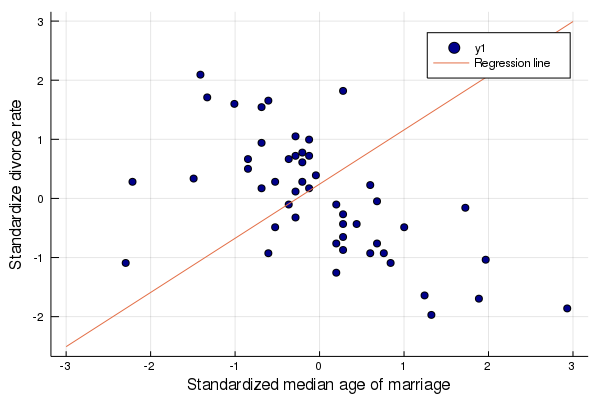

In [10]:
xi = -3.0:0.01:3.0
rws, vars, chns = size(chn)
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[!, :A], df[!, :D], color=:darkblue,
  xlab="Standardized median age of marriage",
  ylab="Standardize divorce rate")
plot!(xi, yi, lab="Regression line")

shade(), abline() and link()

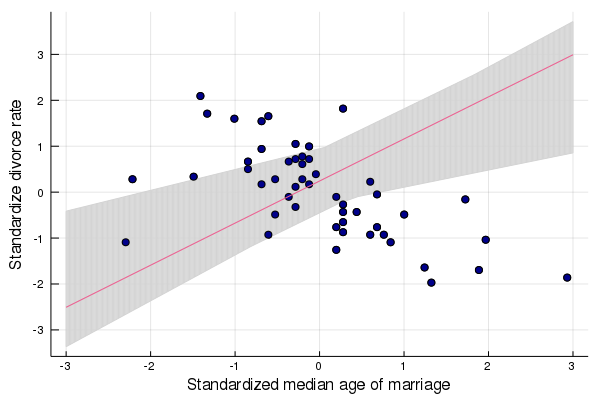

In [11]:
mu = link(xi, chn, [1, 2], mean(xi));
yl = [minimum(mu[i]) for i in 1:length(xi)];
yh =  [maximum(mu[i]) for i in 1:length(xi)];
ym =  [mean(mu[i]) for i in 1:length(xi)];
pi = hcat(xi, yl, ym, yh);
pi[1:5,:]

plot!((xi, yl), color=:lightgrey, leg=false)
plot!((xi, yh), color=:lightgrey, leg=false)
for i in 1:length(xi)
  plot!([xi[i], xi[i]], [yl[i], yh[i]], color=:lightgrey, leg=false)
end
scatter!(df[!, :A], df[!, :D], color=:darkblue)
plot!(xi, yi, lab="Regression line")

End of `05/m5.1s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*